# Make final classifier using harmonic mean
**Goal**: Identify patients that don't respond.
These patients we don't have to treat.

Perform the following steps:

1) Combine data with CNV.

2) Compare harmonic versus delta.

3) Compare clinical data versus clinical and genomic data.

4) Select best classification model based on AUC.

5) For this best model, compare number of molecules.

6) Perform cross validation.

7) Make plots for parameter importance.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from pipelines import benchmark_pipelines, build_classifier_pipelines, pipeline_Freeman
from views import view_linear_model_freeman

# 1) Combine data

In [2]:
from source import read_preprocessed_data
from transform import combine_tsv_files

In [4]:
# Harmonic mean genomic variable.
X_train_hm, y_train_hm = combine_tsv_files(
    "output/train__harmonic_mean__f(t0, t1)__No. Mutant Molecules per mL.tsv",
    "output/train__harmonic_mean__f(t0, t1)__CNV Score.tsv",
)
# Difference genomic variable.
X_train_diff, y_train_diff = combine_tsv_files(
    "output/train__difference__f(t0, t1)__No. Mutant Molecules per mL.tsv",
    "output/train__difference__f(t0, t1)__CNV Score.tsv",
)

# 2) Select best model

In [19]:
y_train_resp = y_train_hm["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'
y_train_resp = y_train_resp == pos_label

In [20]:
ps_class = build_classifier_pipelines()

In [21]:
b_harmonic_mean = benchmark_pipelines(
    ps_class, X_train_hm, y_train_resp, metric='roc_auc',
)

In [22]:
b_difference = benchmark_pipelines(
    ps_class, X_train_diff, y_train_resp, metric='roc_auc',
)

In [9]:
b_harmonic_mean
# print(b.round(2).to_latex())

,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.513561,0.142637,0.572222,0.123744,0.505328,0.059517
RandomForestClassifier,0.549415,0.102203,0.574945,0.115721,0.569116,0.101093
GaussianNB,0.480000,0.088759,0.593424,0.125213,0.526264,0.091075
GradientBoostingClassifier,0.527310,0.063424,0.577446,0.132485,0.589857,0.139692
KNeighborsClassifier,0.499539,0.082748,0.529064,0.058500,0.586283,0.093431
LogisticRegression,0.531040,0.127593,0.525263,0.139646,0.558116,0.102269
SVC,0.552326,0.075078,0.471280,0.061680,0.630903,0.074322
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


In [11]:
print('On average harmonic mean is better by', (b_harmonic_mean.mean(axis=1) - b_difference.mean(axis=1)).mean(), 'ROC AUC')
b_difference

On average harmonic mean is better by -0.001967517509698466 ROC AUC


,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.513561,0.142637,0.531917,0.146731,0.575387,0.138813
RandomForestClassifier,0.549415,0.102203,0.554029,0.101793,0.651858,0.071139
GaussianNB,0.480000,0.088759,0.485874,0.074452,0.383522,0.111320
GradientBoostingClassifier,0.527310,0.063424,0.561826,0.164423,0.644555,0.049097
KNeighborsClassifier,0.499539,0.082748,0.483483,0.089936,0.586933,0.102437
LogisticRegression,0.531040,0.127593,0.573125,0.068456,0.613580,0.140293
SVC,0.552326,0.075078,0.564444,0.093970,0.650045,0.108903
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


The prediction with difference instead of harmonic mean is therefore marginally worse.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


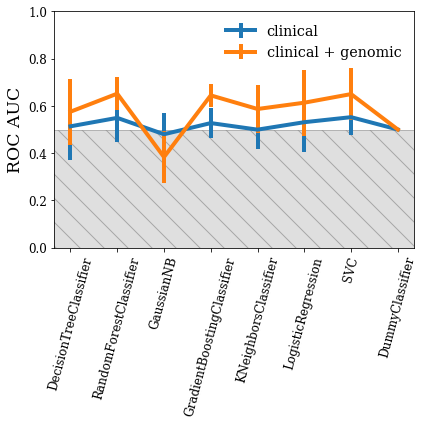

In [12]:
b = b_difference

plt.rc('font', family='serif')
fig = plt.figure(figsize=(6, 6))
degrees=75
plt.ylabel('ROC AUC')
plt.xticks(rotation=degrees)
plt.ylim([0, 1])
plt.gca().fill_between([-1, 8], 0, 0.5, facecolor='grey', edgecolor='k', alpha=0.25, hatch='\\')
plt.errorbar(b.index, b['Richard mean'], yerr=b['Richard std'], label='clinical')
plt.errorbar(b.index, b['Freeman mean'], yerr=b['Freeman std'], label='clinical + genomic')
plt.legend(frameon=False)
# plt.tight_layout()
plt.savefig('figs/comparison_classifiers.png', bbox_inches = 'tight')
plt.savefig('figs/comparison_classifiers.eps', bbox_inches = 'tight')

# 4) Choose model logistic regression.
The logistic regression model doesn't have the best accuracy in absolute terms, but is much simpler than the RandomForest. So by occams razor, we pick it.

In [13]:
random_state=1234
logistic_Freeman_parameters = {
    "random_state": random_state,
#     "penalty": "l2",
#     "class_weight": "balanced",
#     "solver": "newton-cg",
#     "C": 1.0,
#     "max_iter": 10000,
#     'tol': 0.00001,
}
logistic_Freeman = pipeline_Freeman(LogisticRegression, **logistic_Freeman_parameters)

# 6) Cross validation
Find the optimal hyper parameters.

In [14]:
logistic_regression_hyper_parameters = {
#     "transform_columns__age_discretizer__n_bins": (2, 3, 4, 5),
    "filter_rare_mutations__top_k_features": (4, 5, 6, 7, 8, 10, 12, 18, 24, 48),
#     "estimator__l1_ratio": [0.025, 0.05, 0.125, 0.25, 0.375, 0.5, 0.6, 0.75, 0.85, 1.0],
    "estimator__C": [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0],
    "estimator__class_weight": ["balanced", None],
}
clf_search = GridSearchCV(
    logistic_Freeman,
    logistic_regression_hyper_parameters,
    scoring="roc_auc",
    n_jobs=8,
    cv=5,
)

In [15]:
clf_search.fit(X_train_hm, y_train_resp)

/home/hylke/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/hylke/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clinical_curation',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=True,
                                                            func=<function clinical_data_curation at 0x7f5ef0718b90>,
                                                            inv_kw_args=None,
                                                            inverse_func=None,
                                                            kw_args=None,
                                                            pass_y='deprecated',
                                                            validate=False)),
                                       ('remove_specific_phenotypes',
                                        FunctionTrans...
                                              

In [14]:
# print("Best parameters set found on development set:")
# print()
# print(clf_search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf_search.cv_results_['mean_test_score']
# stds = clf_search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf_search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# print()

In [24]:
# # Non-convergent best parameters under elasticnet.
# best_params = {
#     'estimator__C': 2.0,
#     'estimator__class_weight': None,
#     'estimator__l1_ratio': 0.025,
#     "estimator__penalty": "l1",
#     "estimator__solver": "saga",
#     'filter_rare_mutations__top_k_features': 4,
#     'transform_columns__age_discretizer__n_bins': 2,
# }

# Best parameters under L2 norm.
best_params = {
    "estimator__C": 2.0,
    "estimator__class_weight": "balanced",
    "estimator__solver": "newton-cg",
#     "estimator__solver": "saga",
    "filter_rare_mutations__top_k_features": 4,
#     "transform_columns__age_discretizer__n_bins": 2,
}


In [25]:
# assert best_params == clf_search.best_params_

In [26]:
# Pick the best parameteres.
logistic_Freeman.set_params(**best_params)
logistic_Freeman.fit(X_train_hm, y_train_resp)

Pipeline(memory=None,
         steps=[('clinical_curation',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clinical_data_curation at 0x7f5ef0718b90>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('remove_specific_phenotypes',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function...
                                                   'adrenalmeta', 'livermeta',
                                                   'lungmeta', 'skeletonmeta',
                                                   'age'])],
                                   verbose=False)),
                ('estimator',
                 LogisticRegression(C=2.0, class_weight='balanced', dual=False,
     

# 7) Make plots of the model

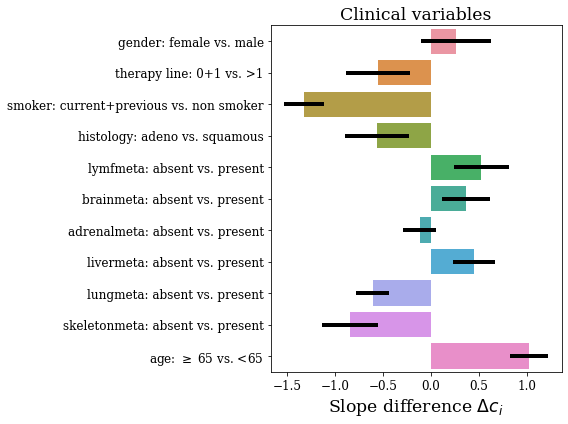

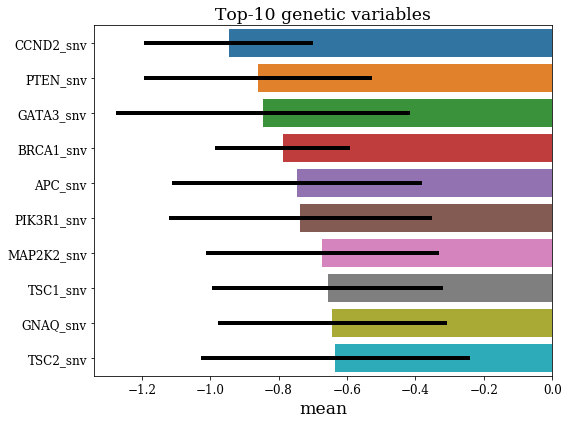

In [28]:
figure_filenames = ("logistic_regression_clinical_freeman", "logistic_regression_genetic_freeman")
view_linear_model_freeman(X_train_hm, y_train_resp, logistic_Freeman, filenames=figure_filenames, thresshold=0.1)